#Ahmad Afif Aulia Hariz

#Data Mounting

In [88]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [89]:
import pandas as pd
import numpy as np

In [90]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/jena_climate_2009_2016.csv')

In [91]:
df=df.head(30000)
df

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,28.07.2009 07:20:00,992.97,15.50,289.24,10.87,73.9,17.64,13.03,4.60,8.20,13.13,1192.39,1.77,3.38,259.5
29996,28.07.2009 07:30:00,993.03,15.49,289.23,10.90,74.1,17.62,13.06,4.56,8.22,13.15,1192.49,1.30,2.25,241.8
29997,28.07.2009 07:40:00,993.15,15.55,289.28,10.76,73.1,17.69,12.93,4.76,8.14,13.02,1192.45,1.57,2.75,234.6
29998,28.07.2009 07:50:00,993.23,15.73,289.45,10.85,72.7,17.90,13.01,4.89,8.19,13.10,1191.77,1.32,3.13,251.7


In [92]:
df.isnull().sum()

Date Time          0
p (mbar)           0
T (degC)           0
Tpot (K)           0
Tdew (degC)        0
rh (%)             0
VPmax (mbar)       0
VPact (mbar)       0
VPdef (mbar)       0
sh (g/kg)          0
H2OC (mmol/mol)    0
rho (g/m**3)       0
wv (m/s)           0
max. wv (m/s)      0
wd (deg)           0
dtype: int64

In [93]:
from sklearn.model_selection import train_test_split
data_train, data_test = train_test_split(df, shuffle=False, test_size=0.2)

In [94]:
data_train

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,16.06.2009 15:20:00,994.32,17.27,290.90,9.84,61.61,19.74,12.16,7.58,7.64,12.23,1187.14,2.02,3.50,269.1
23996,16.06.2009 15:30:00,994.20,17.06,290.70,9.19,59.75,19.48,11.64,7.84,7.31,11.71,1188.09,2.40,5.00,268.2
23997,16.06.2009 15:40:00,994.17,17.06,290.71,8.94,58.75,19.48,11.45,8.04,7.19,11.51,1188.14,1.71,2.75,274.0
23998,16.06.2009 15:50:00,994.28,17.12,290.76,9.13,59.30,19.56,11.60,7.96,7.29,11.66,1187.95,1.80,3.13,332.7


#ML Time Series Proses

In [95]:
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

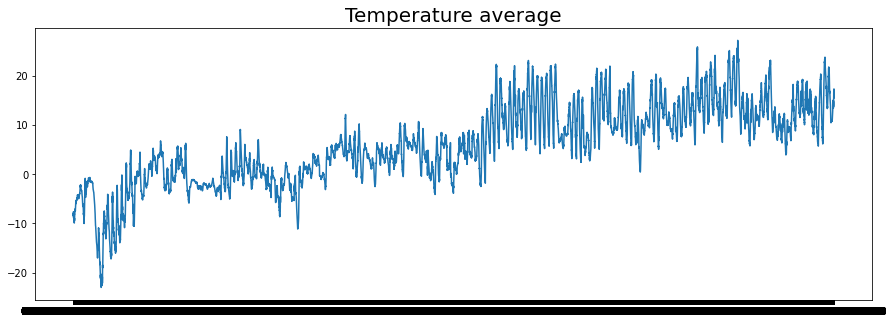

In [96]:
dates = data_train['Date Time'].values
temp  = data_train['T (degC)'].values
 
 
plt.figure(figsize=(15,5))
plt.plot(dates, temp)
plt.title('Temperature average',
          fontsize=20);

In [97]:
dates_test=data_test['Date Time'].values
temp_test=data_test['T (degC)'].values

In [98]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [99]:
train_set = windowed_dataset(temp, window_size=60, batch_size=100, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [100]:
test_set = windowed_dataset(temp_test, window_size=60, batch_size=100, shuffle_buffer=1000)

In [101]:
#Call back technique 
class TestCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('mae') < 1 and logs.get('val_mae') < 1):
            print("\nMae < 1/50!") 
            self.model.stop_training = True 

In [102]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=50, callbacks=[TestCallback()], validation_data=test_set)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/50
240/240 [==============================] - 9s 24ms/step - loss: 7.1680 - mae: 7.6500 - val_loss: 15.8206 - val_mae: 16.3206
Epoch 2/50
240/240 [==============================] - 5s 22ms/step - loss: 6.1484 - mae: 6.6218 - val_loss: 13.2948 - val_mae: 13.7948
Epoch 3/50
240/240 [==============================] - 6s 23ms/step - loss: 3.0422 - mae: 3.4796 - val_loss: 4.1871 - val_mae: 4.6600
Epoch 4/50
240/240 [==============================] - 6s 23ms/step - loss: 1.8333 - mae: 2.2428 - val_loss: 1.9626 - val_mae: 2.3925
Epoch 5/50
240/240 [==============================] - 5s 22ms/step - loss: 0.8363 - mae: 1.1891 - val_loss: 0.7856 - val_mae: 1.1463
Epoch 6/50
240/240 [==============================] - 6s 23ms/step - loss: 0.5926 - mae: 0.9120 - val_loss: 0.5238 - val_mae: 0.8826

Mae < 1/50!


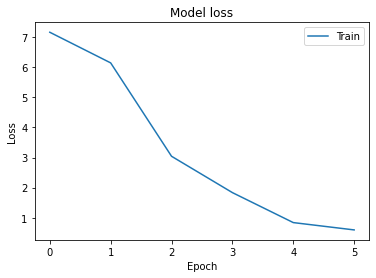

In [103]:
#Plot Loss dan Akurasi dari Trained Model
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

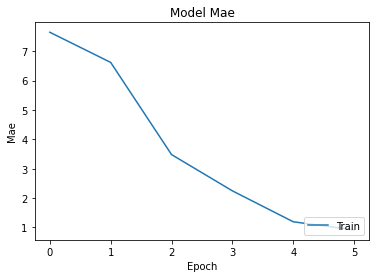

In [104]:
plt.plot(history.history['mae'])
plt.title('Model Mae')
plt.ylabel('Mae')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='lower right')
plt.show()

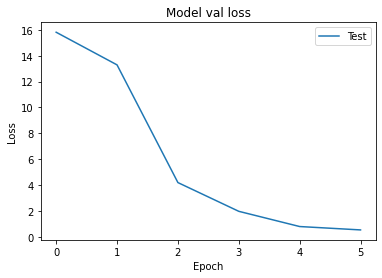

In [105]:
plt.plot(history.history['val_loss'])
plt.title('Model val loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Test'], loc='upper right')
plt.show()

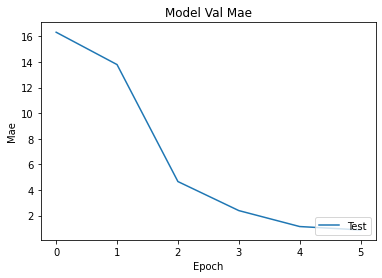

In [106]:
plt.plot(history.history['val_mae'])
plt.title('Model Val Mae')
plt.ylabel('Mae')
plt.xlabel('Epoch')
plt.legend(['Test'], loc='lower right')
plt.show()